In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pylab as plt

import stretchablecorr as sc

## Error evaluation on real images

In [4]:
cube, image_names = sc.load_image_sequence('./images/HS2/')

Load images from ./images/HS2/...
Image sequence:
 23 frames , 1392*1024 pixels , memory size: 250 Mo
 images: 00p000001.TIF, 00p100012.TIF, 00p200023.TIF , ... ,  55p000267.TIF


grid size: 34x21
 i.e. 714 points


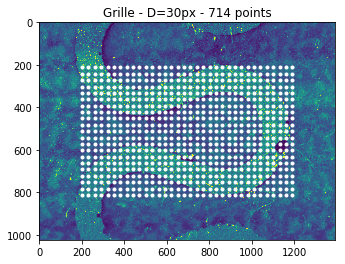

In [8]:
# ==================
#  Define the grid
# ==================

grid_spacing = 30 
grid_margin = 200
# ----
grid = sc.build_grid(cube.shape[1:], margin=grid_margin, spacing=grid_spacing)
points = np.stack( (grid[0].flatten(), grid[1].flatten()), axis=-1 )

# Graph the grid
plt.figure();
plt.title(f'Grille - D={grid_spacing}px - {points.shape[0]} points');
sc.plot_grid_points(grid, background=cube[0],
                    color='white', markersize=3)

## 1. Phase vs CC

In [48]:
results = {}

i_start=1
params = {'window_half_size': 40,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
displ, gap = sc.track_displ_2steps(cube[i_start:i_start+3], points, **params)
results[construct_key(params)] = displ, gap

params = {'window_half_size': 40,
          'coarse_search': True,
          'phase':True,
          'method':'opti' }
displ, gap = sc.track_displ_2steps(cube[i_start:i_start+3], points, **params)
results[construct_key(params)] = displ, gap

done                               
done                               
done                               
done                               
done                               
done                               


In [57]:
bins = np.logspace(-2, 1, 30)

counts, bins = np.histogram(results['40px coarse CC opti'][1].flatten(), bins=bins)
plt.semilogx(bins[:-1], counts, '-o', label='CC opti')

counts, bins = np.histogram(results['40px coarse phase opti'][1].flatten(), bins=bins)
plt.semilogx(bins[:-1], counts, '-o', label='phase opti')

plt.legend();
plt.ylabel('count');
plt.xlabel('log- gap error [px]');
plt.title('HS2 - images n°19, 20 and 21 - 40px')

## Window size

In [67]:
results = {}

i_start=19

params = {'window_half_size': 10,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
displ, gap = sc.track_displ_2steps(cube[i_start:i_start+3], points, **params)
results[construct_key(params)] = displ, gap

params = {'window_half_size': 20,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
displ, gap = sc.track_displ_2steps(cube[i_start:i_start+3], points, **params)
results[construct_key(params)] = displ, gap

params = {'window_half_size': 40,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
displ, gap = sc.track_displ_2steps(cube[i_start:i_start+3], points, **params)
results[construct_key(params)] = displ, gap

done                               
done                               
done                               
done                               
done                               
done                               
done                               
done                               
done                               


Text(0.5, 1.0, 'HS2 - images n°19, 20 and 21')

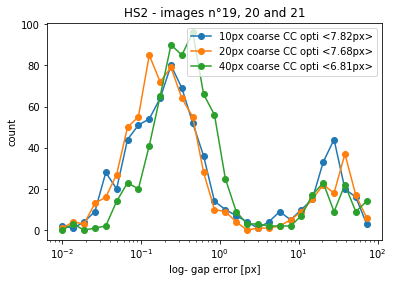

In [72]:
bins = np.logspace(-2, 2, 30)

plt.figure();
for key, res in results.items():
    counts, bins = np.histogram(res[1].flatten(), bins=bins)
    plt.semilogx(bins[:-1], counts, '-o', label=key + f' <{np.mean(res[1].flatten()):.2f}px>')


plt.legend();
plt.ylabel('count');
plt.xlabel('log- gap error [px]');
plt.title('HS2 - images n°19, 20 and 21')

## Draft

In [237]:
def _triangulate_xy(I, J, K, xy, params):
    
    u_ij, err_ij = sc.get_shifts(I, J, *xy, **params)

    xy_j = xy + u_ij
    u_jk, err_jk = sc.get_shifts(J, K, *xy_j, **params)
    x_ijk = xy_j + u_jk

    u_ik, err_ik = sc.get_shifts(I, K, *xy, offset=u_ij+u_jk, **params)
    x_ik = xy + u_ik

    triangle_error = np.sqrt(np.sum((x_ik - x_ijk)**2))
    max_displ = max(np.sqrt(np.sum(u_ij**2)),
                    np.sqrt(np.sum(u_jk**2)),
                    np.sqrt(np.sum(u_ik**2)))
    #estimated_errors = min(err_ij[0], err_ik[0], err_ik[0])  # z-score
    estimated_errors = max(err_ij[1], err_ik[1], err_ik[1])   # FRAE
    return triangle_error, max_displ, estimated_errors


def triangulate(I, J, K, points, params):
    triangle_errors = []
    estimated_errors = []
    distances = []
    for xy in points:
        try:
            triangl_err, max_displ, estim_err = _triangulate_xy(I, J, K, xy, params)
            triangle_errors.append(triangl_err)
            estimated_errors.append(estim_err)
        except ValueError:
            triangle_errors.append(np.NaN)
            estimated_errors.append(np.NaN)
        
    return np.array(triangle_errors), estimated_errors


def construct_key(p):
    name = f"{p['window_half_size']}px"
    if p['coarse_search']:
        name += ' coarse'
    if p['phase']:
        name += ' phase'
    else:
        name += ' CC'
    name += ' ' + p['method']
    return name

In [251]:
# test
ijk = 19, 20, 21
#ijk = 1, 3, 7
IJK = [cube[idx] for idx in ijk]
params = {'window_half_size': 20,
          'coarse_search': True,
          'phase': False,
          'method':'opti' }
triangle_errors, estimated_errors  = triangulate(*IJK, points, params)

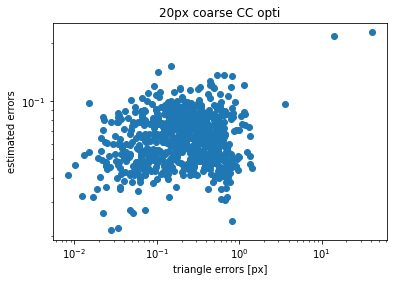

In [252]:
plt.loglog(triangle_errors, estimated_errors, 'o')
plt.title(construct_key(params)); plt.xlabel('triangle errors [px]')
plt.ylabel('estimated errors');

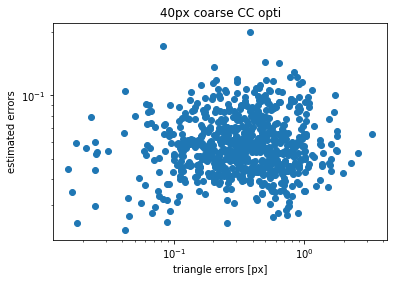

In [248]:
plt.loglog(triangle_errors, estimated_errors, 'o')
plt.title(construct_key(params)); plt.xlabel('triangle errors [px]')
plt.ylabel('estimated errors');

In [215]:
argsorted = np.argsort(triangle_errors)

pts = argsorted[-5]
print(pts, points[pts], triangle_errors[pts], estimated_errors[pts])

467 [951 602] 29.97594259222222 1.7448026161777206


In [216]:
params = {'window_half_size': 40,
          'coarse_search': True,
          'phase':False,
          'method':'opti' }
_triangulate_xy(*IJK, points[pts], params)

(29.97594259222222, 40.060814072604174, 1.7448026161777206)

[-18.51420486  18.9008512 ]
[-9.79580117  9.91093529]
[-27.90431375  29.45917826]
triangle_error 0.7640041400900274
triangle_error 0.7640041400899296


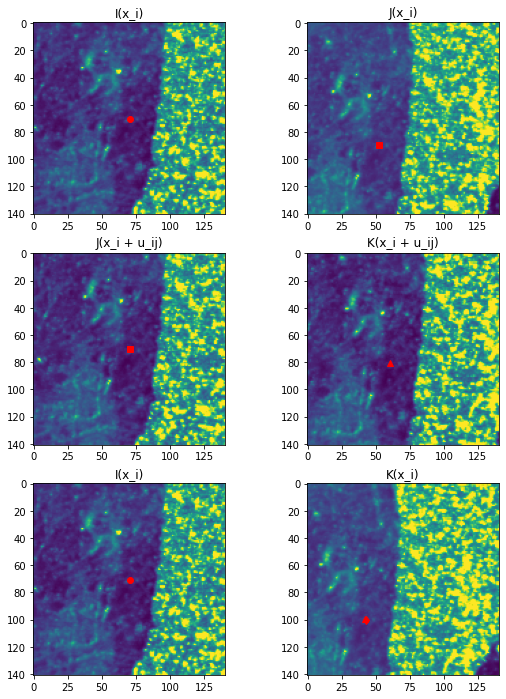

In [217]:
ijk = 19, 20, 21
#ijk = 1, 3, 7
IJK = [cube[idx] for idx in ijk]

window_half_size = 70
params = {'window_half_size': window_half_size,
          'coarse_search': False,
          'phase':True,
          'method':'opti' }

I, J, K = IJK
xy_i = points[pts]

u_ij, err_ij = sc.get_shifts(I, J, *xy_i, **params)
print(u_ij)

xy_j = xy_i + u_ij
u_jk, err_jk = sc.get_shifts(J, K, *xy_j, **params)
x_ijk = xy_j + u_jk
print(u_jk)

u_ik, err_ik = sc.get_shifts(I, K, *xy_i, offset=u_ij+u_jk, **params)
x_ik = xy_i + u_ik
C, ij = sc.crop(K, xy_i, window_half_size)
print(u_ik)


fig, axes = plt.subplots(3, 2, figsize=(9,12))

A0, ij = sc.crop(I, xy_i, window_half_size)
B0, ij = sc.crop(J, xy_i, window_half_size)
C0, ij = sc.crop(K, xy_i, window_half_size)

a0 = np.array(A0.shape)/2
b0 = a0 + u_ij[::-1]
c0 = a0 + u_jk[::-1]
c1 = a0 + u_ik[::-1]
c2 = a0 + u_ij[::-1] + u_jk[::-1]

ax1 = axes[0, 0]
ax1.imshow(A0); ax1.plot(*a0[::-1], 'or'); ax1.set_title('I(x_i)');

ax2 = axes[0, 1]
ax2.imshow(B0); ax2.plot(*b0[::-1], 'sr'); ax2.set_title('J(x_i)');

B1, ij = sc.crop(J, xy_j, window_half_size)
C1, ij = sc.crop(K, xy_j, window_half_size)
ax3 = axes[1, 0]
ax3.imshow(B1); ax3.plot(*a0[::-1], 'sr'); ax3.set_title('J(x_i + u_ij)');

ax4 = axes[1, 1]
ax4.imshow(C1); ax4.plot(*c0[::-1], '^r'); ax4.set_title('K(x_i + u_ij)');

ax5 = axes[2, 0]
ax5.imshow(A0); ax5.plot(*a0[::-1], 'or'); ax5.set_title('I(x_i)');

ax6 = axes[2, 1]
ax6.imshow(C0); ax6.plot(*c1[::-1], 'dr'); ax6.set_title('K(x_i)');
ax6.plot(*c2[::-1], '^r');

print('triangle_error', np.sqrt(np.sum((x_ik - x_ijk)**2)))
print('triangle_error', np.sqrt(np.sum((u_ij + u_jk - u_ik)**2)))

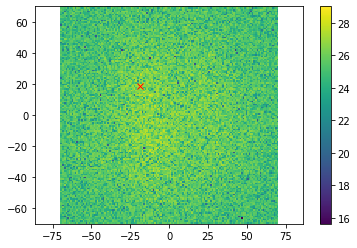

In [234]:
dx_span, dy_span, cross_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=1, phase=True)

argmax_idx = np.unravel_index(np.argmax(cross_corr), cross_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]
argmax_idx_cc = argmax_idx 
plt.pcolor(dx_span, dy_span, np.log(cross_corr))
plt.plot(*argmax[::-1], 'xr'); plt.colorbar();
plt.axis('equal');
#plt.xlim([-10, 10]);
#plt.ylim([-10, 14]);

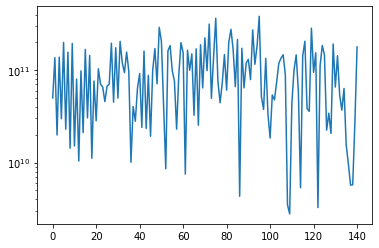

In [235]:
plt.semilogy(cross_corr[0, :])

In [202]:
from scipy.ndimage import laplace

In [204]:
Lcc = laplace(cross_corr)

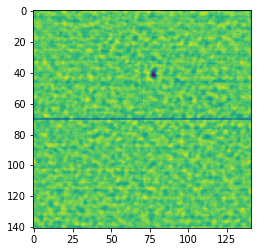

In [206]:
plt.imshow(Lcc)

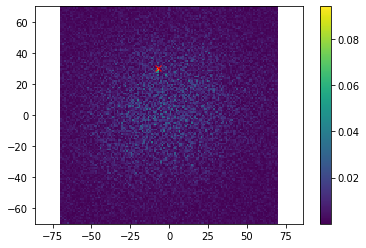

In [200]:
dx_span, dy_span, phase_corr, res = sc.output_cross_correlation(A0, B0,
                                                                upsamplefactor=1, phase=True)

argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]

plt.pcolor(dx_span, dy_span, phase_corr)
plt.plot(*argmax[::-1], 'xr'); plt.colorbar();
plt.axis('equal');
#plt.xlim([-10, 10]);
#plt.ylim([-10, 14]);

In [207]:
cross_corr = Lcc

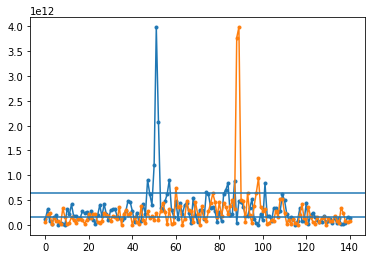

In [236]:
plt.plot(cross_corr[:, argmax_idx[1]], '.-')
plt.plot(cross_corr[argmax_idx[0], :], '.-')
plt.axhline(y=np.mean(cross_corr));
plt.axhline(y=np.mean(cross_corr) + 3*np.std(cross_corr));

In [ ]:
half = int( (auto_corr.shape[0] - 1 )/2 )
plt.plot(auto_corr[:, half], '-')
plt.plot(auto_corr[half, :], '-')

# def two_steps_tracker(I, J, K, x_i, params):
    
    # i -> j
    u_ij, err_ij = sc.get_shifts(I, J, *x_i, **params)

    # j -> k
    x_ij = x_i + u_ij
    u_jk, err_jk = sc.get_shifts(J, K, *x_j, **params)
    x_ijk = x_j + u_jk

    # i -> k
    u_ik, err_ik = sc.get_shifts(I, K, *x_i, **params)
    x_ik = x_i + u_ik

    triangle_error = np.sqrt(np.sum((x_ik - x_ijk)**2))
    
    x_j_avg = (x_ij + 0.5*(x_ik-u_jk))/1.5
    
    return x_j_avg, triangle_error

In [ ]:
points[pts]

In [ ]:
sc.track_displ_img_to_img?

In [ ]:
points[1, None]

In [41]:
def track_displ_2steps(cube, points, **params):
    displ1, err1 = sc.track_displ_img_to_img(cube, points,
                                             **params)

    displ2a, err2a = sc.track_displ_img_to_img(cube[0::2], points,
                                               **params)
    displ2b, err2b = sc.track_displ_img_to_img(cube[1::2], points,
                                               **params)

    displ2 = np.zeros((displ2a.shape[0] + displ2b.shape[0], 
                       displ2b.shape[1],
                       displ2b.shape[2]))

    displ2[0::2] = displ2a
    displ2[1::2] = displ2b

    triangle_gap = displ1[:-1] + displ1[1:] - displ2
    triangle_gap = np.sqrt(np.sum(triangle_gap**2, axis=-1))
    
    return displ1, triangle_gap

In [26]:
plt.imshow(phase_corr > np.min(phase_corr) + np.ptp(phase_corr)*0.8)

NameError: name 'phase_corr' is not defined

In [ ]:
displ, err = sc.get_shifts(A, B, *np.array(A.shape)/2,
           window_half_size=A.shape[0]//2-1,
           coarse_search=False,
           phase=False,
           method='opti')
print(displ, err)

In [ ]:
plt.pcolor(phase_corr);
plt.plot(*(-np.array(res)), 'rx')
plt.colorbar(); plt.axis('equal');

In [ ]:
print(displ,res)
plt.figure();
plt.pcolor(dx_span, dy_span, phase_corr.T);
plt.plot(*(-np.array(res)), 'rx')
plt.colorbar(); plt.axis('equal');

In [ ]:
argmax_idx = np.unravel_index(np.argmax(phase_corr), phase_corr.shape)

plt.imshow(phase_corr.T)
plt.plot(*argmax_idx, 'ow'); plt.colorbar();

In [ ]:
phase_corr[argmax_idx]

In [ ]:
argmax = dy_span[argmax_idx[0]], dx_span[argmax_idx[1]]

In [ ]:
from scipy.ndimage import convolve, correlate

In [ ]:
window_half_size = 100
A, ij = sc.crop(I, points[pts], window_half_size)
B, ij = sc.crop(J, points[pts], window_half_size//4)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);

In [ ]:
%%timeit
CC = correlate(A, B)

In [ ]:
plt.imshow(CC)

In [ ]:
results = {}
ijk = 0, 2, 4
#ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

coarse_search = True
params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)


params = {'window_half_size': 20,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 40,
          'coarse_search':coarse_search,
          'phase': True,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 7,
          'coarse_search':coarse_search,
          'phase': False,
          'method':'opti' }
results[construct_key(params)] = triangulate(*IJK, points, params)

In [ ]:
from tabulate import tabulate

In [ ]:
table_data = [{'params':k,
               'count':len(row[0]),
               'mean err':np.mean(row[0]),
               'max err':np.max(row[0])} for k, row in results.items()]

In [ ]:
print( tabulate(table_data, headers='keys') )

In [ ]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

In [ ]:
for key, (errors, distances) in results.items():
    d_mean = np.mean(errors)
    n, bins = np.histogram(errors);
    plt.plot(bins[:-1], n, label=key)
    
    plt.plot(d_mean, np.interp(d_mean, bins[:-1], n), 'o')

plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

In [ ]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

In [ ]:
print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0])}'
       for k in sorted_results]))

In [ ]:
plt.imshow(distances_grid);
plt.colorbar();

In [ ]:
results = {}
ijk = 17, 18, 19
IJK = [cube[idx] for idx in ijk]

params = {'window_half_size': 40,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': False,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

params = {'window_half_size': 15,
          'coarse_search':True,
          'phase': True,
          'method':'opti' }

results[construct_key(params)] = triangulate(*IJK, points, params)

for key, distances in results.items():
    n, bins = np.histogram(distances);
    plt.semilogy(bins[:-1], n, label=key)
    
plt.legend(); plt.xlabel('error [px]')
plt.ylabel('count');

## windows size choice

In [ ]:
results = {}
#ijk = 17, 18, 19
ijk = 0, 8, 16
IJK = [cube[idx] for idx in ijk]

windows_size_span = [5, 10, 15, 20, 30, 40, 60, 80]

coarse_search = True
for whs in windows_size_span:
    print(whs)
    params = {'window_half_size': whs,
              'coarse_search':coarse_search,
              'phase': False,
              'method':'opti' }
    results[construct_key(params)] = triangulate(*IJK, points, params)

In [ ]:
sorted_results = sorted(list(results.items()), key=lambda x:np.mean(x[1][0]))

print('\n'.join([f'{k[0]:<20} {np.mean(k[1][0]): 7.2f} {np.mean(k[1][1])}'
       for k in sorted_results]))

ijk = 0, 2, 4

    40px_coarse_CC_opti     0.09 2.259973140522304
    30px_coarse_CC_opti     0.10 2.2622871765443
    20px_coarse_CC_opti     0.12 2.261829636143824
    15px_coarse_CC_opti     0.13 2.2634306646659104
    10px_coarse_CC_opti     0.14 2.26663557199468
    5px_coarse_CC_opti      0.27 2.298498600568171

    40px_coarse_phase_opti    0.15 2.2654455306205796
    30px_coarse_phase_opti    0.16 2.264311597123281
    20px_coarse_phase_opti    0.20 2.3456869633174007
    15px_coarse_phase_opti    0.21 2.3517071681117967
    10px_coarse_phase_opti    0.31 2.389567565122548
    5px_coarse_phase_opti    0.58 2.3683886448966254


ijk = 17, 18, 19

    20px_coarse_CC_opti    12.61 31.070749300731286
    10px_coarse_CC_opti    13.57 29.295575670259872
    30px_coarse_CC_opti    13.62 31.880018045480217
    15px_coarse_CC_opti    13.92 29.910678115302705
    40px_coarse_CC_opti    14.69 32.93321053537991
    5px_coarse_CC_opti     16.87 29.68630756901744


    5px_coarse_phase_opti   13.49 27.914897056628146
    40px_coarse_phase_opti   14.77 31.255842745998883
    10px_coarse_phase_opti   14.87 28.596095838056392
    30px_coarse_phase_opti   15.20 30.92854706730653
    20px_coarse_phase_opti   16.15 30.535217185822052
    15px_coarse_phase_opti   16.28 30.15249085909452


In [ ]:
sc.output_cross_correlation()